# Survival Analysis of Full Cohort 

**This notebook analyzes median overall survival and hazard ratios in patients with advanced or metastatic urothelial cancer. The analysis compares patients receiving first-line monotherapy with monotherapy checkpoint inhibitors (pembrolizumab [KEYNOTE-361] or atezolizumab [IMvigor130]) versus those receiving chemotherapy.** 

In [1]:
import numpy as np
import pandas as pd

from flatiron_cleaner import DataProcessorUrothelial

from iptw_survival import IPTWSurvivalEstimator

import matplotlib.pyplot as plt

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

## Process mortality data 

In [3]:
cohort = pd.read_csv('../outputs/full_cohort.csv')

In [4]:
cohort.sample(3)

,PatientID,LineName,StartDate
3301,FA02787D6A27C,chemo,2017-03-13
161,FE2105E05471B,Atezolizumab,2018-04-30
2840,FC3E18E545776,chemo,2019-08-06


In [5]:
cohort.shape

(6461, 3)

In [6]:
processor = DataProcessorUrothelial()

# Process Enhanced_Mortality_V2.csv and use visit, telemedicine, biomarkers, oral, and progression data to determine censoring date 
mortality_df = processor.process_mortality(file_path = '../data/Enhanced_Mortality_V2.csv',
                                           index_date_df = cohort, 
                                           index_date_column = 'StartDate',
                                           visit_path = '../data/Visit.csv', 
                                           telemedicine_path = '../data/Telemedicine.csv', 
                                           biomarkers_path = '../data/Enhanced_AdvUrothelialBiomarkers.csv', 
                                           oral_path = '../data/Enhanced_AdvUrothelial_Orals.csv',
                                           progression_path = '../data/Enhanced_AdvUrothelial_Progression.csv',
                                           drop_dates = False)

2025-04-22 20:12:59,182 - INFO - Successfully read Enhanced_Mortality_V2.csv file with shape: (9040, 2) and unique PatientIDs: 9040
2025-04-22 20:12:59,194 - INFO - Successfully merged Enhanced_Mortality_V2.csv df with index_date_df resulting in shape: (6461, 3) and unique PatientIDs: 6461
2025-04-22 20:12:59,661 - INFO - The following columns ['last_visit_date', 'last_biomarker_date', 'last_oral_date', 'last_progression_date'] are used to calculate the last EHR date
2025-04-22 20:12:59,667 - INFO - Successfully processed Enhanced_Mortality_V2.csv file with final shape: (6461, 6) and unique PatientIDs: 6461. There are 0 out of 6461 patients with missing duration values


In [7]:
mortality_df.head(3)

,PatientID,imported_StartDate,DateOfDeath,event,last_ehr_activity,duration
0,F5AAF96C85477,2021-07-08,NaT,0,2021-09-14,68.0
1,F788831A66E9A,2023-02-22,NaT,0,2023-05-11,78.0
2,F75847DF35E43,2019-04-25,2019-06-15,1,2019-05-28,51.0


In [8]:
mortality_df.shape

(6461, 6)

In [9]:
mortality_df = pd.merge(mortality_df, cohort[['PatientID', 'LineName']], on = 'PatientID', how = 'left')

In [10]:
mortality_df.shape

(6461, 7)

In [11]:
mortality_df.rename(columns={'imported_StartDate': 'StartDate'}, inplace=True)

In [12]:
mortality_df.to_csv('../outputs/full_cohort_with_death_data.csv', index = False)

In [13]:
mortality_df = mortality_df.query('duration >= 0')

In [14]:
mortality_df.shape

(6446, 7)

In [15]:
mortality_df['treatment'] = ((mortality_df['LineName'] == 'Pembrolizumab') | (mortality_df['LineName'] == 'Atezolizumab')).astype(int)

## Merge cleaned data from data_cleaning_auto.ipynb

In [16]:
dtype_map = pd.read_csv('../outputs/final_df_dtypes.csv', index_col = 0).iloc[:, 0].to_dict()
df = pd.read_csv('../outputs/final_df.csv', dtype = dtype_map)

In [17]:
df.head(3)

,PatientID,DiseaseGrade,SmokingStatus,Surgery,GroupStage_mod,TStage_mod,NStage_mod,MStage_mod,SurgeryType_mod,days_diagnosis_to_adv,...,drug_abuse,psychoses,depression,van_walraven_score,lymph_met,thoracic_met,liver_met,bone_met,other_gi_met,other_combined_met
0,F0016E985D839,High grade (G2/G3/G4),1,1,IV,T3,N1,M0,upper,0.0,...,0,0,0,4,0,0,0,0,0,0
1,F001E5D4C6FA0,Low grade (G1),1,1,unknown,T1,unknown,unknown,bladder,274.0,...,0,0,0,<NA>,0,0,0,0,0,0
2,F0025BA658AE1,High grade (G2/G3/G4),1,0,unknown,T3,unknown,M0,NaN,621.0,...,0,0,0,4,0,0,0,0,0,0


In [18]:
df.shape

(6461, 149)

In [19]:
df = pd.merge(mortality_df[['PatientID' , 'event', 'duration', 'treatment']], df, on = 'PatientID', how = 'left')

In [20]:
df.shape

(6446, 152)

## Merge insurance and SES information from insurance_ses.ipynb

In [21]:
insurance_ses_df = pd.read_csv('../outputs/insurance_ses_df.csv')

In [22]:
insurance_ses_df.head(3)

,PatientID,commercial,medicaid,medicare,other_insurance,ses_mod
0,F5AAF96C85477,0,0,1,0,1 - Lowest SES
1,F788831A66E9A,1,0,1,0,1 - Lowest SES
2,F75847DF35E43,1,0,0,1,2-4


In [23]:
insurance_ses_df.shape

(6461, 6)

In [24]:
insurance_ses_df['ses_mod'] = insurance_ses_df['ses_mod'].astype('category')

In [25]:
df = pd.merge(df, insurance_ses_df, on = 'PatientID', how = 'left')

In [26]:
df.shape

(6446, 157)

## Survival Analysis 

### Preprocessing

In [30]:
(
    df.groupby('treatment')['event']
    .apply(lambda x: (x == 0).mean())
)

treatment
0    0.306741
1    0.298749
Name: event, dtype: float64

In [31]:
df['creatinine_2'] = np.where(df['creatinine'] > 2, 1, 0)

In [39]:
df.groupby(['adv_diagnosis_year', 'treatment']).size().unstack(fill_value=0)

/var/folders/lr/vkkcj_s12115sxc05ly3mshh0000gn/T/ipykernel_29847/868052135.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['adv_diagnosis_year', 'treatment']).size().unstack(fill_value=0)


treatment,0,1
adv_diagnosis_year,,
2011,192,2
2012,302,3
2013,329,4
2014,355,5
2015,441,28
2016,441,133
2017,367,278
2018,304,335
2019,347,365


In [44]:
df['adv_diagnosis_year'] = df['adv_diagnosis_year'].astype(int)

In [49]:
df['before_2020'] = np.where(df['adv_diagnosis_year'] < 2020, 1, 0)

### IPTW 

In [47]:
estimator = IPTWSurvivalEstimator()

In [50]:
# We apply stabilized IPTW and clip propensity scores to the [0.01, 0.99] range to reduce the influence of extreme values
estimator.fit(df = df,
              treatment_col = 'treatment',
              cat_var = ['GroupStage_mod', 'ecog_index', 'ses_mod', 'PDL1_status'],
              cont_var = ['days_diagnosis_to_adv', 'age', 'weight_index', 'percent_change_weight', 'albumin', 'total_bilirubin', 'van_walraven_score'],
              binary_var = ['Surgery', 'opioid', 'commercial', 'medicaid', 'creatinine_2', 'before_2020'],
              lr_kwargs = {
                  'class_weight': 'balanced',
                  'solver': 'lbfgs',
                  'penalty': 'l2',
                  'max_iter': 1000,
                  'random_state': 42
              },
              clip_bounds = (0.01, 0.99),
              stabilized = True,)

In [51]:
iptw_df = estimator.transform()

In [52]:
ps_fig = estimator.propensity_score_plot(bins = 30)

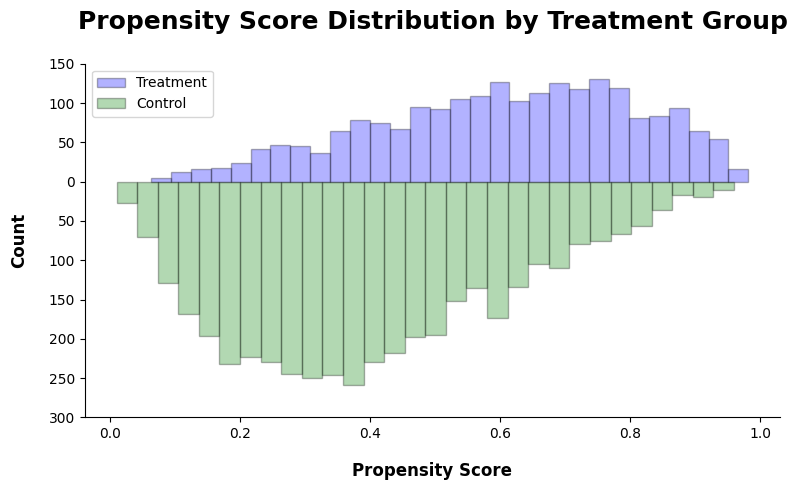

In [53]:
ps_fig

In [54]:
smd_df, smd_fig = estimator.standardized_mean_differences(return_fig = True)

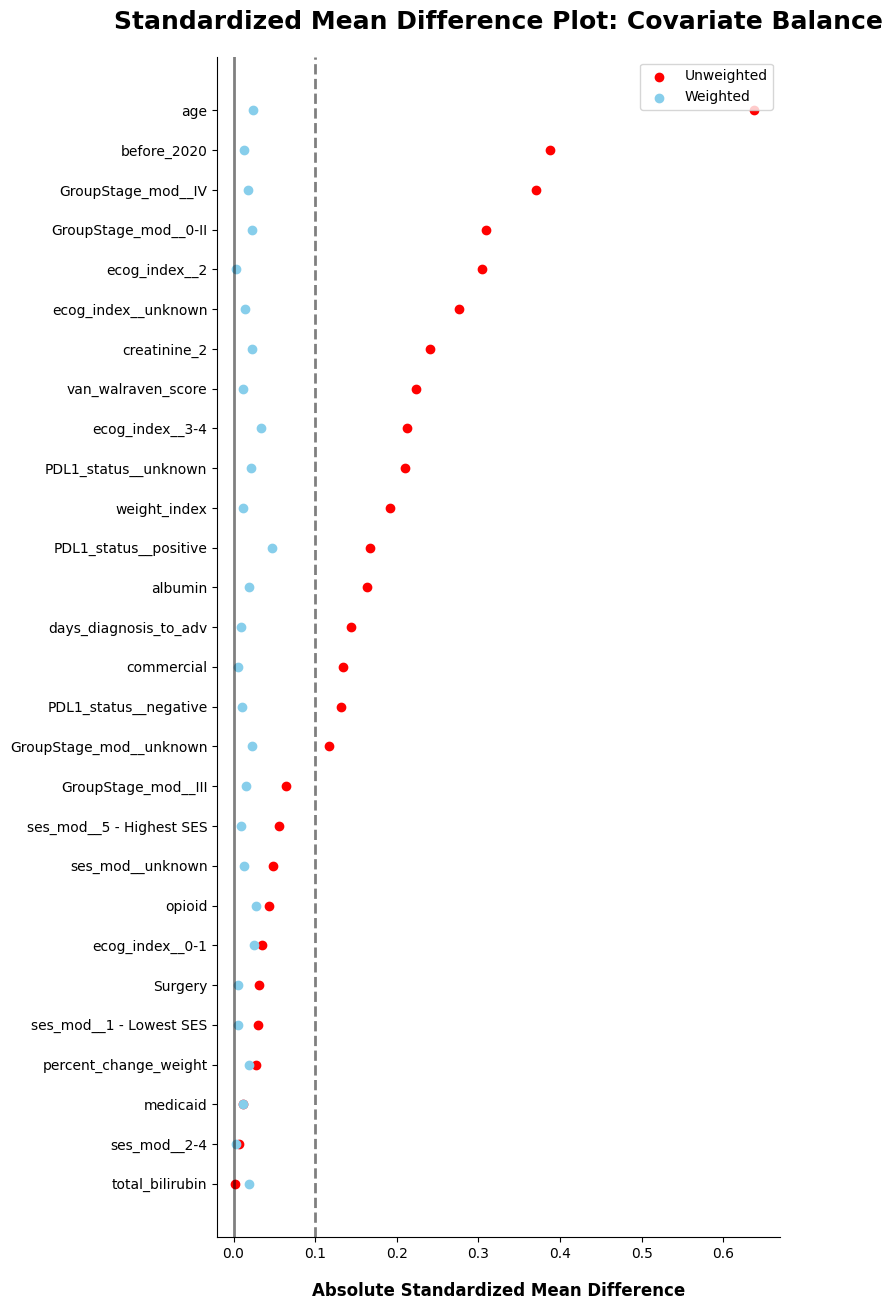

In [55]:
smd_fig

In [56]:
# Convert days to month
iptw_df['duration'] = iptw_df['duration']/30

In [57]:
km_confidence_intervals_df = estimator.km_confidence_intervals(df = iptw_df,
                                                               duration_col = 'duration',
                                                               event_col = 'event',
                                                               weight_col = 'iptw',
                                                               n_bootstrap = 1000,
                                                               random_state = 42)

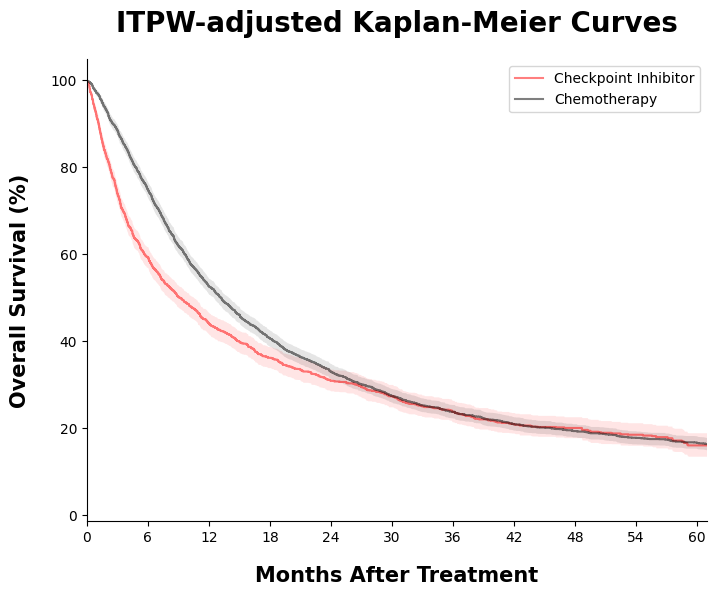

In [58]:
fig = plt.figure(figsize=(8, 6))

# Pembrolizumab arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.treatment_estimate * 100, 
         color = 'red', 
         alpha = 0.5,
         label = 'Checkpoint Inhibitor')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.treatment_lower_ci * 100, 
                 km_confidence_intervals_df.treatment_upper_ci * 100, 
                 facecolor = 'red', 
                 alpha = 0.1)

# Chemotherapy arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.control_estimate * 100, 
         color = 'black', 
         alpha = 0.5,
         label = 'Chemotherapy')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.control_lower_ci * 100, 
                 km_confidence_intervals_df.control_upper_ci * 100, 
                 facecolor = 'black', 
                 alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.title('ITPW-adjusted Kaplan-Meier Curves', size = 20, weight = 'bold',  pad = 20)
plt.ylabel('Overall Survival (%)', size = 15, weight = 'bold', labelpad = 15)
plt.xlabel('Months After Treatment', size = 15, weight = 'bold', labelpad = 15)
plt.legend(prop = {'size': 10})

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)